In [1]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

%matplotlib inline

warnings.filterwarnings("ignore")
SEED = 23

In [2]:
df = pd.read_csv('/Users/ira/Downloads/REALEC_Inspector/results/classification_dataset.csv')
df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,punct_mistakes_because,punct_mistakes_but,punct_mistakes_compare,million_mistake,side_mistake,name,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,0,0,0,0,0,./data/exam/exam2017/OBy_146_1,This two line graphs illustrates monthly avera...,60,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,0,0,0,0,0,./data/exam/exam2017/EGe_15_1,"﻿We have two graphics, which show us the popul...",65,1,0


# Multiclass

In [3]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/multiclass_distribution.png')
plt.clf()

<Figure size 1440x720 with 0 Axes>

In [4]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['class']

In [5]:
get_numeric_data = FunctionTransformer(lambda x: x[feature_columns], validate=False)

def build_model(classifier):
    model = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ]))
        ])),
        ('clf', classifier)
    ])
    return model

In [6]:
model = build_model(classifier=LogisticRegression(multi_class='ovr',
                                                  class_weight='balanced',
                                                  random_state=SEED))
y_pred = cross_val_predict(model, X, y, cv=10)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          10       0.00      0.00      0.00         1
          15       0.06      0.40      0.11         5
          20       0.06      0.11      0.07         9
          25       0.00      0.00      0.00        10
          30       0.11      0.29      0.15        14
          35       0.04      0.20      0.07        20
          40       0.02      0.12      0.04        33
          45       0.06      0.22      0.10        69
          50       0.14      0.17      0.15       215
          55       0.22      0.12      0.16       585
          60       0.45      0.34      0.38      1279
          65       0.32      0.19      0.24       816
          69       0.00      0.00      0.00         1
          70       0.23      0.29      0.26       307
          75       0.04      0.17      0.06        69
          80       0.03      0.17      0.05         6
          85       0.00      0.00      0.00         2

   micro avg       0.24   

# Binary classification

In [7]:
targets = []
for t in df['class']:
    if int(t) >= 70:
        targets.append('best')
    else:
        targets.append('not_best')
df['class'] = targets

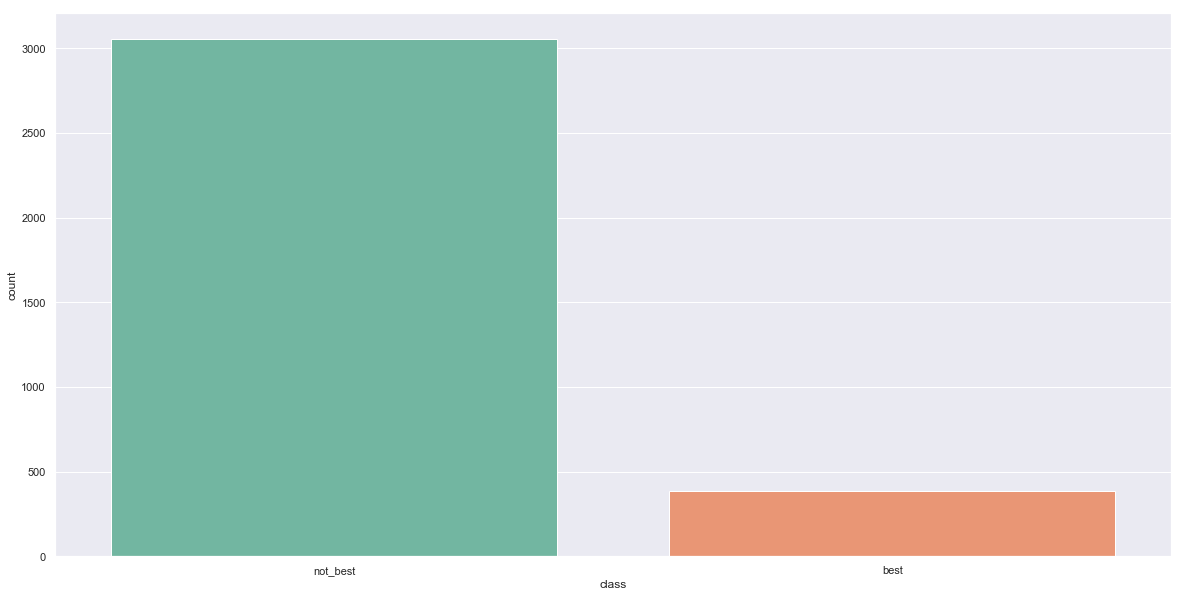

In [8]:
sns_plt = sns.countplot(x='class', data=df, palette="Set2")
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/binary_class_distribution.png')

In [9]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['class']

## LogisticRegression

In [10]:
sns.set(rc={'figure.figsize':(5, 3)})

In [33]:
def get_info(classifier, X, y, classes=['non_best', 'best']):
    model = build_model(classifier=classifier)
    y_pred = cross_val_predict(model, X, y, cv=10)
    print(classification_report(y, y_pred))
    conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
    sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                          yticklabels=classes,
                          xticklabels=classes)

              precision    recall  f1-score   support

        best       0.23      0.66      0.34       384
    not_best       0.94      0.72      0.82      3057

   micro avg       0.71      0.71      0.71      3441
   macro avg       0.59      0.69      0.58      3441
weighted avg       0.86      0.71      0.76      3441



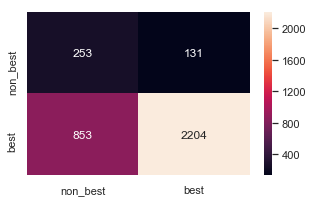

In [12]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X, y)

## RandomForestClassifier

              precision    recall  f1-score   support

        best       0.54      0.06      0.10       384
    not_best       0.89      0.99      0.94      3057

   micro avg       0.89      0.89      0.89      3441
   macro avg       0.72      0.53      0.52      3441
weighted avg       0.85      0.89      0.85      3441



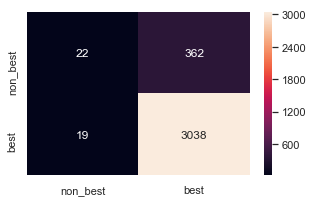

In [13]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X, y)

## KNeighborsClassifier

              precision    recall  f1-score   support

        best       0.26      0.07      0.11       384
    not_best       0.89      0.98      0.93      3057

   micro avg       0.87      0.87      0.87      3441
   macro avg       0.58      0.52      0.52      3441
weighted avg       0.82      0.87      0.84      3441



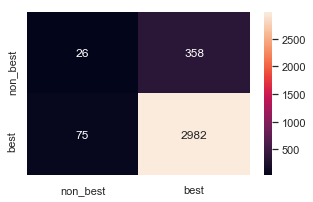

In [14]:
get_info(KNeighborsClassifier(), X, y)

# Balance class
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

## Random under-sampling

In [15]:
count_class_0, count_class_1 = df['class'].value_counts()
df_class_0 = df[df['class'] == 'not_best']
df_class_1 = df[df['class'] == 'best']

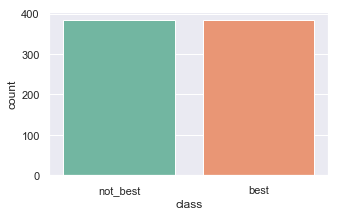

In [16]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)
sns_plt = sns.countplot(x='class', data=df_under, palette="Set2")

In [17]:
X = df_under[feature_columns]
y = df_under['class']

### LogisticRegression

              precision    recall  f1-score   support

        best       0.71      0.67      0.69       384
    not_best       0.69      0.72      0.70       384

   micro avg       0.70      0.70      0.70       768
   macro avg       0.70      0.70      0.70       768
weighted avg       0.70      0.70      0.70       768



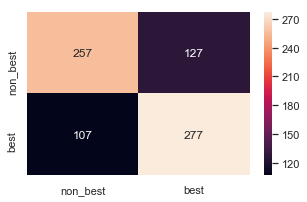

In [18]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X, y)

### RandomForestClassifier

              precision    recall  f1-score   support

        best       0.68      0.68      0.68       384
    not_best       0.68      0.67      0.68       384

   micro avg       0.68      0.68      0.68       768
   macro avg       0.68      0.68      0.68       768
weighted avg       0.68      0.68      0.68       768



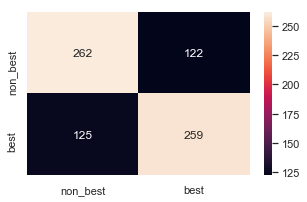

In [19]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X, y)

### KNeighborsClassifier

              precision    recall  f1-score   support

        best       0.60      0.61      0.61       384
    not_best       0.61      0.60      0.60       384

   micro avg       0.60      0.60      0.60       768
   macro avg       0.60      0.60      0.60       768
weighted avg       0.60      0.60      0.60       768



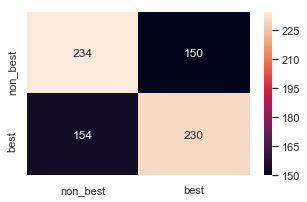

In [20]:
get_info(KNeighborsClassifier(), X, y)

# Python imbalanced-learn module

## Undersampling

In [21]:
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=feature_columns)

### LogisticRegression

              precision    recall  f1-score   support

        best       0.69      0.66      0.68       384
    not_best       0.68      0.71      0.69       384

   micro avg       0.68      0.68      0.68       768
   macro avg       0.69      0.68      0.68       768
weighted avg       0.69      0.68      0.68       768



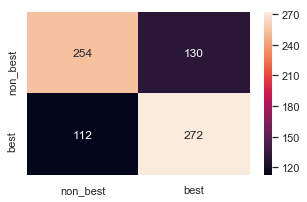

In [22]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_rus, y_rus)

### RandomForestClassifier

              precision    recall  f1-score   support

        best       0.68      0.72      0.70       384
    not_best       0.70      0.66      0.68       384

   micro avg       0.69      0.69      0.69       768
   macro avg       0.69      0.69      0.69       768
weighted avg       0.69      0.69      0.69       768



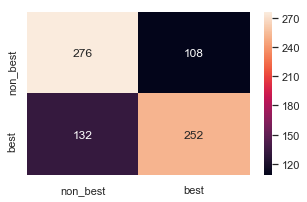

In [23]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X_rus, y_rus)

### KNeighborsClassifier

              precision    recall  f1-score   support

        best       0.62      0.62      0.62       384
    not_best       0.62      0.62      0.62       384

   micro avg       0.62      0.62      0.62       768
   macro avg       0.62      0.62      0.62       768
weighted avg       0.62      0.62      0.62       768



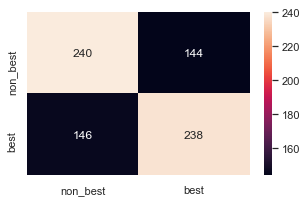

In [24]:
get_info(KNeighborsClassifier(), X_rus, y_rus)

## Oversampling

In [25]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)
X_ros = pd.DataFrame(X_ros, columns=feature_columns)

### LogisticRegression

              precision    recall  f1-score   support

        best       0.71      0.67      0.69       384
    not_best       0.69      0.72      0.70       384

   micro avg       0.70      0.70      0.70       768
   macro avg       0.70      0.70      0.70       768
weighted avg       0.70      0.70      0.70       768



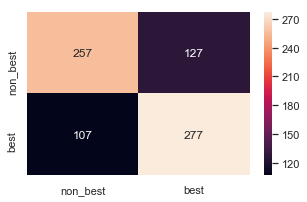

In [26]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_ros, y_ros)

### RandomForestClassifier

              precision    recall  f1-score   support

        best       0.68      0.68      0.68       384
    not_best       0.68      0.67      0.68       384

   micro avg       0.68      0.68      0.68       768
   macro avg       0.68      0.68      0.68       768
weighted avg       0.68      0.68      0.68       768



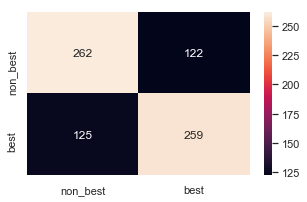

In [27]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X_ros, y_ros)

### KNeighborsClassifier

              precision    recall  f1-score   support

        best       0.60      0.61      0.61       384
    not_best       0.61      0.60      0.60       384

   micro avg       0.60      0.60      0.60       768
   macro avg       0.60      0.60      0.60       768
weighted avg       0.60      0.60      0.60       768



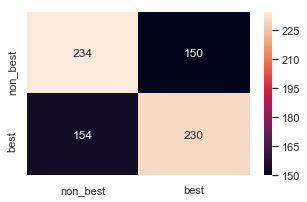

In [29]:
get_info(KNeighborsClassifier(), X_ros, y_ros)

# Type prediction

In [31]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['type']

              precision    recall  f1-score   support

           1       0.98      0.99      0.98      1699
           2       0.99      0.98      0.98      1742

   micro avg       0.98      0.98      0.98      3441
   macro avg       0.98      0.98      0.98      3441
weighted avg       0.98      0.98      0.98      3441



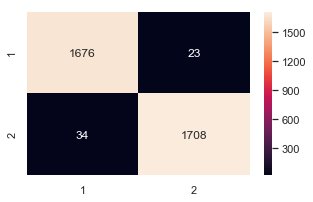

In [34]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X, y, classes=['1', '2'])

In [40]:
df_1 = df[df['type'] == 1]
df_2 = df[df['type'] == 2]

In [41]:
X = df_1[feature_columns]
y = df_1['class']
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=feature_columns)

              precision    recall  f1-score   support

        best       0.70      0.62      0.66       181
    not_best       0.66      0.73      0.70       181

   micro avg       0.68      0.68      0.68       362
   macro avg       0.68      0.68      0.68       362
weighted avg       0.68      0.68      0.68       362



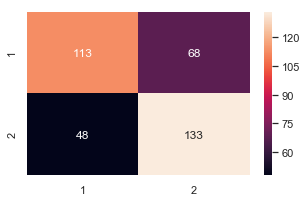

In [42]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_rus, y_rus, classes=['1', '2'])

In [43]:
X = df_2[feature_columns]
y = df_2['class']
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=feature_columns)

              precision    recall  f1-score   support

        best       0.70      0.67      0.68       203
    not_best       0.68      0.71      0.70       203

   micro avg       0.69      0.69      0.69       406
   macro avg       0.69      0.69      0.69       406
weighted avg       0.69      0.69      0.69       406



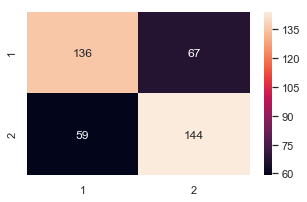

In [44]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_rus, y_rus, classes=['1', '2'])

# TF_IDF